In [27]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt

In [28]:
data = xr.open_dataset("../AQ - Experiments/data/delhi_cpcb_2022.nc")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [29]:
df = data.to_dataframe()
# df = df["2022-01-01": "2022-12-31"]
df = data.to_dataframe().reset_index()
df = df[df["time"]=="2022-01-01 01:30:00"]
indices_to_drop = [96614, 316189, 342538]

# Drop the rows with the given indices
df = df.drop(indices_to_drop)


In [30]:
df.head()

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,RH,WS,WD,SR,BP,AT,RF,TOT-RF,latitude,longitude
1,"Alipur, Delhi - DPCC",2022-01-01 01:30:00,2022-01-01 01:00:00,2022-01-01 02:00:00,224.50,360.25,89.30,44.70,96.60,5.50,...,82.23,NaN,206.05,4.60,998.90,6.72,0.0,0.0,28.815329,77.153010
8784,"Anand Vihar, Delhi - DPCC",2022-01-01 01:30:00,2022-01-01 01:00:00,2022-01-01 02:00:00,684.00,892.00,313.38,73.83,294.77,68.20,...,87.62,0.30,220.50,8.88,974.90,11.52,NaN,0.0,28.647622,77.315809
17567,"Ashok Vihar, Delhi - DPCC",2022-01-01 01:30:00,2022-01-01 01:00:00,2022-01-01 02:00:00,510.50,618.25,166.85,35.32,154.80,46.33,...,94.12,0.25,162.43,5.83,993.33,10.17,0.0,0.0,28.695381,77.181665
26350,"Aya Nagar, Delhi - IMD",2022-01-01 01:30:00,2022-01-01 01:00:00,2022-01-01 02:00:00,187.95,283.37,12.40,30.75,43.16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.470691,77.109936
35133,"Bawana, Delhi - DPCC",2022-01-01 01:30:00,2022-01-01 01:00:00,2022-01-01 02:00:00,293.00,451.25,61.50,19.62,81.05,59.17,...,84.82,0.43,171.95,5.62,998.80,7.53,0.0,0.0,28.776200,77.051074


In [31]:
df = df.rename(columns={"RH": "relative_humidity", "WS": "wind_speed", "WD": "wind_direction", "SR": "solar_radiation", "BP": "pressure", "AT": "temperature", "RF": "rain_fall", "TOT-RF": "total_rainfall"})
df.columns

Index(['station', 'time', 'From Date', 'To Date', 'PM2.5', 'PM10', 'NO', 'NO2',
       'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene',
       'relative_humidity', 'wind_speed', 'wind_direction', 'solar_radiation',
       'pressure', 'temperature', 'rain_fall', 'total_rainfall', 'latitude',
       'longitude'],
      dtype='object')

In [32]:
df.head(n=1)

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,relative_humidity,wind_speed,wind_direction,solar_radiation,pressure,temperature,rain_fall,total_rainfall,latitude,longitude
1,"Alipur, Delhi - DPCC",2022-01-01 01:30:00,2022-01-01 01:00:00,2022-01-01 02:00:00,224.5,360.25,89.3,44.7,96.6,5.5,...,82.23,NaN,206.05,4.6,998.9,6.72,0.0,0.0,28.815329,77.15301


In [33]:
import networkx as nx
import math

# Define the distance threshold (in kilometers)
distance_threshold = 11

# Create an empty nx graph
G = nx.Graph()

# Iterate through each node in the dataset
for i in range(len(df)):
    lat1, lon1 = df.iloc[i]['latitude'], df.iloc[i]['longitude']
    pm = df.iloc[i]['PM2.5']
    
    # Add the current node to the nx graph
    G.add_node(i, latitude=lat1, longitude=lon1, pm=pm)

    # Iterate through the remaining nodes
    for j in range(i + 1, len(df)):
        lat2, lon2 = df.iloc[j]['latitude'], df.iloc[j]['longitude']
        
        # Calculate the distance between the coordinates using the Haversine formula
        radius = 6371  # Earth's radius in kilometers
        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)
        a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = radius * c
        
        # Check if the distance is below the threshold
        if distance <= distance_threshold:
            # Add an edge between the current pair of nodes in the nx graph
            G.add_edge(i, j)

# Now you have the nx graph where nodes represent the data points with latitude and longitude as features, and edges represent nodes within the distance threshold


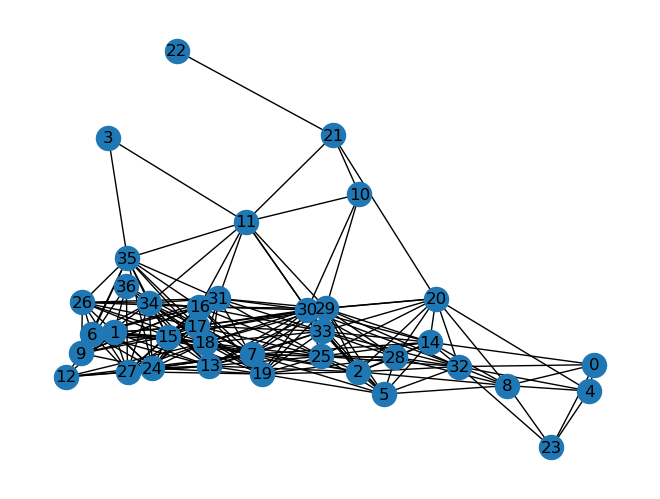

In [34]:
layout = nx.spring_layout(G, k=0.5)

# Draw the graph with the specified layout
nx.draw(G, pos=layout, with_labels=True)


In [35]:
lat_lon_dict = {}
for node in G.nodes:
    lat_lon_dict[node] = (G.nodes[node]['latitude'], G.nodes[node]['longitude'])


In [36]:
import folium
import networkx as nx
from folium.plugins import FastMarkerCluster

# Create a NetworkX graph (G) and calculate node positions (lat_lon_dict)

# Create a Folium map centered on Delhi
m = folium.Map(location=[28.7041, 77.1025], zoom_start=10)

# Create a MarkerCluster layer for better performance
marker_cluster = FastMarkerCluster(data=list(lat_lon_dict.values()))
m.add_child(marker_cluster)

# Iterate over the edges and add them to the map as lines
for u, v in G.edges:
    lat1, lon1 = lat_lon_dict[u]
    lat2, lon2 = lat_lon_dict[v]
    folium.PolyLine([(lat1, lon1), (lat2, lon2)], color='gray', weight=1).add_to(m)

# Iterate over the nodes and add them to the map as markers
for node, (lat, lon) in lat_lon_dict.items():
    folium.CircleMarker(location=(lat, lon), radius=5, color='blue', fill=True, fill_color='blue').add_to(m)

# Display the map
m


In [37]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.data import Data, Dataset
# from torch_geometric.nn import GCNConv

# # Step 1: Convert NetworkX graph to PyTorch Geometric Data object
# # Assuming your NetworkX graph is named 'G'
# node_features = [(G.nodes[node]['latitude'], G.nodes[node]['longitude']) for node in G.nodes]
# edge_index = torch.tensor(list(G.edges)).t().contiguous()
# y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)

# data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y)

# # Step 2: Define a custom PyTorch Geometric dataset
# class MyDataset(Dataset):
#     def __init__(self, data):
#         super(MyDataset, self).__init__()
#         self.data = data

#     def len(self):
#         return len(self.data)

#     def get(self, idx):
#         return self.data[idx]

# dataset = MyDataset(data)

# # Step 3: Implement a regression model using PyTorch Geometric
# class RegressionModel(nn.Module):
#     def __init__(self, input_dim):
#         super(RegressionModel, self).__init__()
#         self.conv1 = GCNConv(input_dim, 16)
#         self.conv2 = GCNConv(16, 1)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = self.conv2(x, edge_index)
#         return x

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = RegressionModel(input_dim=2).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = nn.MSELoss()

# model.train()
# for epoch in range(100):
#     optimizer.zero_grad()
#     out = model(data.x.to(device), data.edge_index.to(device))
#     loss = criterion(out, data.y.to(device))
#     loss.backward()
#     optimizer.step()

# model.eval()
# with torch.no_grad():
#     out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
#     rmse = torch.sqrt(torch.mean((out - data.y.to(device))**2))
#     print('RMSE:', rmse.item())

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv

# Step 1: Convert NetworkX graph to PyTorch Geometric Data object
# Assuming your NetworkX graph is named 'G'
node_features = [(G.nodes[node]['latitude'], G.nodes[node]['longitude']) for node in G.nodes]
edge_index = torch.tensor(list(G.edges)).t().contiguous()
y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)
train_mask[:25] = True
test_mask[25:] = True

data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask)

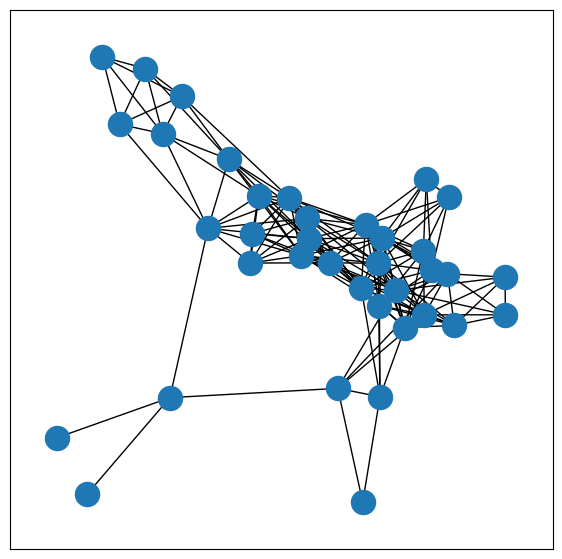

In [39]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,)
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()
    
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [40]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 10)
        self.linear1 = nn.Linear(10, 10)
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x


In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegressionModel(input_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [42]:
model

RegressionModel(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 10)
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
train_rmse_list = []
test_rmse_list = []

In [44]:
from tqdm import tqdm


for epoch in tqdm(range(2500)):
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%100==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()



100%|██████████| 2500/2500 [00:01<00:00, 1467.32it/s]


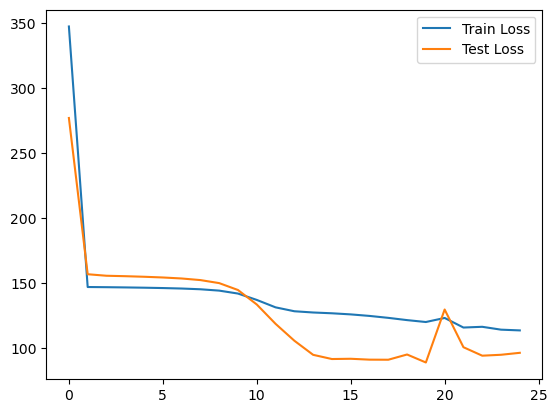

In [45]:
import matplotlib.pyplot as plt

# Assuming you have train_loss_list and test_loss_list as lists containing the respective losses

# Plotting train loss
plt.plot(range(len(train_rmse_list)), train_rmse_list, label='Train Loss')



# Plotting test loss
plt.plot(range(len(test_rmse_list)), test_rmse_list, label='Test Loss')

plt.legend()
plt.show()

In [46]:
model.eval()
with torch.no_grad():
    out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
    print(f"train rmse:{train_rmse}")
    print(f"test rmse: {test_rmse}")

train rmse:116.77456665039062
test rmse: 89.65424346923828


In [52]:
lat_lon = data.x
out = model(data.x.to(device), data.edge_index.to(device))

torch.Size([37, 2])

In [55]:
heat_map = []
for i in range(len(lat_lon)):
    heat_map.append((lat_lon[i][0], lat_lon[i][1], out[i].item()))


In [62]:
import folium
from folium.plugins import HeatMap
import branca.colormap as cm
import branca

# Assuming you have a list of tuples 'heat_map' with (latitude, longitude, pm_prediction) values

# Create a Folium map centered around Delhi
delhi_map = folium.Map(location=[28.7041, 77.1025], zoom_start=10)

# Create a list of coordinates and values for the heatmap
heat_data = [[lat, lon, pm] for lat, lon, pm in heat_map]
steps=20
colormap = branca.colormap.linear.YlOrRd_09.scale(0, 1).to_step(steps)

colormap.add_to(delhi_map) #add color bar at the top of the map
# Add the heatmap layer to the map
HeatMap(heat_data, radius=15).add_to(delhi_map)

# Display the map
delhi_map


In [25]:
train_mean = torch.mean(data.y[data.train_mask])
torch.sqrt(torch.mean((train_mean - data.y[data.test_mask].squeeze())**2))

tensor(89.3758)

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Step 1: Prepare the data
X_train = data.x[data.train_mask].numpy()
y_train = data.y[data.train_mask].numpy().reshape(-1)
X_test = data.x[data.test_mask].numpy()
y_test = data.y[data.test_mask].numpy().reshape(-1)

# Step 2: Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 3: Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Step 4: Evaluate the model
train_rmse = torch.sqrt(torch.mean((torch.tensor(y_train_pred) - data.y[data.train_mask])**2))
test_rmse = torch.sqrt(torch.mean((torch.tensor(y_test_pred) - data.y[data.test_mask])**2))

print('Train RMSE:', train_rmse.item())
print('Test RMSE:', test_rmse.item())


Train RMSE: 154.28965211930898
Test RMSE: 109.14006668038826


In [ ]:
save_path = 'model.pt'
torch.save(model.state_dict(), save_path)


In [ ]:
features = df.drop(columns=['station', 'PM2.5','time', 'From Date', 'To Date'])
target = df['PM2.5']

In [146]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv

# Step 1: Convert NetworkX graph to PyTorch Geometric Data object
# Assuming your NetworkX graph is named 'G'
node_features = [(G.nodes[node]['latitude'], G.nodes[node]['longitude']) for node in G.nodes]
edge_index = torch.tensor(list(G.edges)).t().contiguous()
y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)

data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y)
train_mask = Data(x=data.x[0:31], edge_index=data.edge_index, y=data.y[:31])
test_mask = Data(x=data.x[31:], edge_index=data.edge_index, y=data.y[31:])

# Step 2: Define a custom PyTorch Geometric dataset
class MyDataset(Dataset):
    def __init__(self, data):
        super(MyDataset, self).__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = MyDataset(train_mask)
test_dataset = MyDataset(test_mask)

# Step 4: Create data loaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Step 5: Implement a regression model using PyTorch Geometric
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Step 6: Train and evaluate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RegressionModel(input_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

model.train()
for epoch in range(100):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch: {epoch+1}, Train Loss: {avg_loss}")

model.eval()
with torch.no_grad():
    total_rmse = 0
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        rmse = torch.sqrt(criterion(out, batch.y))
        total_rmse += rmse.item()
    
    avg_rmse = total_rmse / len(test_loader)
    print(f"Test RMSE: {avg_rmse}")


TypeError: Can't instantiate abstract class MyDataset with abstract methods get, len

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity
# import networkx as nx
# cosine_sim = cosine_similarity(features)


ValueError: Input contains NaN.